In [ ]:
import nltk
import tensorflow as tf
import pandas as pd
import json 
from tensorflow.keras.preprocessing .text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, GlobalMaxPooling1D , Flatten
from tensorflow.keras.models import Model

In [ ]:
%%writefile content.json
{"intents": [
        {"tag": "greeting",
         "patterns": ["Hi", "How are you", "Is anyone there?", "Hello", "Good day"],
         "responses": ["Hello, thanks for visiting", "Good to see you again", "Hi there, how can I help?"],
         "context_set": ""
        },
        {"tag": "goodbye",
         "patterns": ["Bye", "See you later", "Goodbye"],
         "responses": ["See you later, thanks for visiting", "Have a nice day", "Bye! Come back again soon."]
        },
        {"tag": "thanks",
         "patterns": ["Thanks", "Thank you", "That's helpful"],
         "responses": ["Happy to help!", "Any time!", "My pleasure"]
        },
        {"tag": "hours",
         "patterns": ["What hours are you open?", "What are your hours?", "When are you open?" ],
         "responses": ["We're open every day 9am-9pm", "Our hours are 9am-9pm every day"]
        },
        {"tag": "location",
         "patterns": ["What is your location?", "Where are you located?", "What is your address?", "Where is your restaurant situated?" ],
         "responses": ["We are on the intersection of London Alley and Bridge Avenue.", "We are situated at the intersection of London Alley and Bridge Avenue", "Our Address is: 1000 Bridge Avenue, London EC3N 4AJ, UK"]
        },
        {"tag": "payments",
         "patterns": ["Do you take credit cards?", "Do you accept Mastercard?", "Are you cash only?" ],
         "responses": ["We accept VISA, Mastercard and AMEX", "We accept most major credit cards"]
        },
        {"tag": "todaysmenu",
         "patterns": ["What is your menu for today?", "What are you serving today?", "What is today's special?"],
         "responses": ["Today's special is Chicken Tikka", "Our speciality for today is Chicken Tikka"]
        },
        {"tag": "deliveryoption",
         "patterns": ["Do you provide home delivery?", "Do you deliver the food?", "What are the home delivery options?" ],
         "responses": ["Yes, we provide home delivery through UBER Eats and Zomato?", "We have home delivery options through UBER Eats and Zomato"],
         "context_set": "food"
        },
        {"tag": "menu",
         "patterns": ["What is your Menu?", "What are the main course options?", "Can you tell me the most delicious dish from the menu?", "What is the today's special?"],
         "responses": ["You can visit www.mymenu.com for menu options", "You can check out the food menu at www.mymenu.com", "You can check various delicacies given in the food menu at www.mymenu.com"],
         "context_filter": "food"
        }
   ]
}


Writing content.json


In [ ]:
#importing the dataset
with open("content.json") as content:
  data1= json.load(content)
type(data1)

dict

In [ ]:
#getting all the data to lists
tags=[]
inputs=[]
responses={}
for intent  in data1["intents"]:
  responses[intent["tag"]]=intent["responses"]
  for line in intent["patterns"]:
    inputs.append(line)
    tags.append(intent["tag"])
len(inputs)

31

In [ ]:
#convert to dataframe
data=pd.DataFrame({"inputs":inputs
              ,"tags":tags})

In [ ]:
#preprocessing
#remove punctuation
import string
data["inputs"]=data["inputs"].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
data["inputs"]=data["inputs"].apply(lambda wrd:"".join(wrd))

In [ ]:
data.head()

,inputs,tags
0,hi,greeting
1,how are you,greeting
2,is anyone there,greeting
3,hello,greeting
4,good day,greeting


In [ ]:
#tokenize the data
tokenizer=Tokenizer(num_words=2000)
tokenizer.fit_on_texts(data["inputs"])
train=tokenizer.texts_to_sequences(data["inputs"])
#apply padding
from tensorflow.keras.preprocessing.sequence import pad_sequences
x_train=pad_sequences(train)
#encoding the tagsS
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
y_train=le.fit_transform(data["tags"])
y_train

array([2, 2, 2, 2, 2, 1, 1, 1, 7, 7, 7, 3, 3, 3, 4, 4, 4, 4, 6, 6, 6, 8,
       8, 8, 0, 0, 0, 5, 5, 5, 5])

In [ ]:
input_shape=x_train.shape[1]
input_shape
x_train

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 18],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 19,  3,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  4, 20, 21],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 22],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 23, 24],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 25],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 26,  1, 27],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 28],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 29],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 30,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 31, 32],
       [ 0,  0,  0,  0,  0,  0,  2,  9,  3,  1, 10],
       [ 0,  0,  0,  0,  0,  0,  0,  2,  3,  5,  9],
       [ 0,  0,  0,  0,  0,  0,  0, 33,  3,  1, 10],
       [ 0,  0,  0,  0,  0,  0,  0,  2,  4,  5, 34],
       [ 0,  0,  0,  0,  0,  0,  0, 11,  3,  1, 35],
       [ 0,  0,  0,  0,  0,  0,  0,  2,  4,  5, 36],
       [ 0,  0,  0,  0,  0,  0, 11,  4,  5, 37, 38],
       [ 0,  0,  0,  0,  0,  0,  7,  1, 39, 40

In [ ]:
#define vocabulary
tokenizer.word_index
#dictionnaire{mot:son code(token)} contient l'ensemble des mots qui construisent ttes les phrases de l'input
vocabulary=len(tokenizer.word_index)
print("number of unique words is: ",vocabulary)
le.classes_
#liste des classes d'output  (tag:greeting, goodbye,thanks...)
output_length=le.classes_.shape[0]
print('output length: ',output_length)

number of unique words is:  59
output length:  9


In [ ]:
#creating the model
i=Input(shape=(input_shape,))
x=Embedding(vocabulary+1,10)(i)
x=LSTM(10,return_sequences=True)(x)
x=Flatten()(x)
x=Dense(output_length,activation="softmax")(x)
model=Model(i,x)

In [ ]:
#compiling Model
model.compile(loss="sparse_categorical_crossentropy",optimizer="adam",metrics=["accuracy"])

In [ ]:
#trainig the model 
model_train=model.fit(x_train,y_train,epochs=200)

Epoch 1/200
1/1 [==============================] - 2s 2s/step - loss: 2.1998 - accuracy: 0.0968
Epoch 2/200
1/1 [==============================] - 0s 17ms/step - loss: 2.1985 - accuracy: 0.0968
Epoch 3/200
1/1 [==============================] - 0s 17ms/step - loss: 2.1973 - accuracy: 0.1935
Epoch 4/200
1/1 [==============================] - 0s 15ms/step - loss: 2.1960 - accuracy: 0.1613
Epoch 5/200
1/1 [==============================] - 0s 17ms/step - loss: 2.1948 - accuracy: 0.1613
Epoch 6/200
1/1 [==============================] - 0s 19ms/step - loss: 2.1936 - accuracy: 0.1613
Epoch 7/200
1/1 [==============================] - 0s 22ms/step - loss: 2.1924 - accuracy: 0.1290
Epoch 8/200
1/1 [==============================] - 0s 19ms/step - loss: 2.1912 - accuracy: 0.2258
Epoch 9/200
1/1 [==============================] - 0s 19ms/step - loss: 2.1899 - accuracy: 0.2581
Epoch 10/200
1/1 [==============================] - 0s 14ms/step - loss: 2.1887 - accuracy: 0.2581
Epoch 11/200
1/1 [===

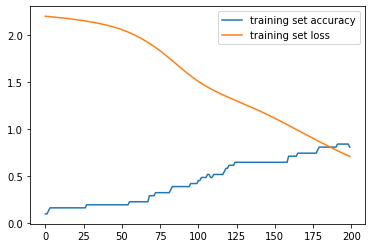

In [ ]:
#plotting model accuracy
import matplotlib.pyplot as plt
plt.plot(model_train.history["accuracy"],label="training set accuracy")
plt.plot(model_train.history["loss"],label="training set loss")
plt.legend()


In [ ]:
#chatting
import random
import numpy as np


while True:
  texts_p=[]
  prediction_input=input("You: ")
  #removing puntuation and convert to lowercase
  prediction_input=[letters.lower() for letters in prediction_input if letters not in string.punctuation]
  prediction_input="".join(prediction_input)
  texts_p.append(prediction_input)
  #tokenizing and padding
  prediction_input= tokenizer.texts_to_sequences(texts_p)
  prediction_input=np.array(prediction_input).reshape(-1)
  prediction_input=pad_sequences([prediction_input],input_shape)
  #getting output from model
  output=model.predict(prediction_input)
  output=output.argmax()
  #finding the right tag and predicting
  response_tag=le.inverse_transform([output])[0]
  print("Bohmiid: ",random.choice(responses[response_tag]))
  if response_tag =="goodbye":
    break
print(prediction_input)



You: bye
Bohmiid:  See you later, thanks for visiting
[[ 0  0  0  0  0  0  0  0  0  0 25]]


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 11)]              0         
                                                                 
 embedding (Embedding)       (None, 11, 10)            600       
                                                                 
 lstm (LSTM)                 (None, 11, 10)            840       
                                                                 
 flatten (Flatten)           (None, 110)               0         
                                                                 
 dense (Dense)               (None, 9)                 999       
                                                                 
Total params: 2,439
Trainable params: 2,439
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from tkinter import *

In [ ]:
from flask import Flask
app=Flask(__name__)
@app.route("/")
def hello():
    return "hello word"


In [ ]:
from joblib import dump,load

In [ ]:
model_in=load("model.joblib")

In [ ]:
model_in.predict(np.array([[ 0 , 0 , 0 , 0  ,0 , 0 , 0,  0 , 0 , 0 ,25]]))

array([[2.6050436e-03, 4.8148888e-01, 2.5065404e-01, 4.9223669e-04,
        2.1423118e-03, 3.4304458e-04, 7.9711396e-03, 2.5066698e-01,
        3.6362263e-03]], dtype=float32)

In [ ]:
ch = None
